# IBM Data Science Professional Certificate - Capstone Project

Assume you’re moving to a city you now nothing about. You got this great opportunity, but it is in a whole different state/country. You have no family or connections there, so you can’t just ask for suggestions. Google is useful, but you first have to know what to search for. As an example, Hamburg has 103 neighborhoods. Where to start? General searches, such as “Where to live in Hamburg?”, will find hundreds of pages worth of information. But without some firsthand knowledge, how to separate the good advice from the bad? Or to know if whoever wrote the advice has similar priorities to yours?  

In those circumstances, a data driven approach can help you jumpstart your search the right way and can be done using a recommender system. On an individual level, if you can cross-reference what types of businesses or amenities are available in each neighborhood with their average rent prices, how safe they are and how far they are from your work place, for example, you can direct your searches towards a handful of preferred locations as opposed to the whole city. And you would know, in advance, that those neighborhoods/quarters are suited for your own personal preferences. On a business level, realtors or real state agencies could develop short questionnaires to probe a client’s preferences and use that to get tailored recommendations for each potential client. City administration, itself, could add such questionnaires to their own websites and produce these recommendations for anyone looking to move into the city.

In [65]:
# This is the module import cell
import bs4
import glob
import json
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from requests import get
from datetime import datetime
from geopy.geocoders import Nominatim
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## 1. We start by gathering information about the neighborhoods in Hamburg (Stadtteilen).
#### We start off by reading our geojson file that contains all neighborhoods in Hamburg. We will use this file to create our initial dataframe, with all neighborhoods + their latitude and longitude coordinates.

In [2]:
geojson_file = json.load(open(r'hamburg_neighborhoods.geojson'))

neighborhoods = [(f['properties']['name'], 
                  np.squeeze(f['geometry']['coordinates']).mean(axis = 0)[1],
                  np.squeeze(f['geometry']['coordinates']).mean(axis = 0)[0]) for f in geojson_file['features']]
hamburg_neigh = pd.DataFrame(index = np.arange(len(neighborhoods)), columns = ['Neighborhood', 'Latitude', 'Longitude'], data = neighborhoods)
hamburg_neigh.head()

Neighborhood   Latitude  Longitude
0      Spadenland  53.490067  10.064322
1  Rothenburgsort  53.530373  10.052995
2      Neuenfelde  53.510943   9.788074
3           Cranz  53.534694   9.773858
4    Finkenwerder  53.534365   9.829963

In [4]:
hamburg_neigh.shape

(103, 3)

#### According to the above, we have 103 neighborhoods in Hamburg. Let's visualize them in a Choropleth map.

In [5]:
hamburg_neigh_map = folium.Map(location = [hamburg_neigh.Latitude.mean(), hamburg_neigh.Longitude.mean()], zoom_start = 10)
 
# Add the color for the chloropleth:
hamburg_neigh_map.choropleth(geo_data = geojson_file, name = 'Hamburg Neighborhoods',
                             key_on = 'feature.properties.name', fill_opacity = 0.8, highlight = True)
folium.LayerControl().add_to(hamburg_neigh_map)

hamburg_neigh_map

## 2. Now that we have our neighborhoods, let's start gathering the data we need for our recommender system for the city of Hamburg.
#### Scraping all the listing data from immobilienscout24 and getting all venue information from Foursquare can take a while, depending on how much data we are obtaining. Also, this is not information that becomes irrelevant the next day. For that reason, we will save our finished content matrix at the end of the data gathering step and will just load it back up again when re-running the notebook. 
#### To make sure that the information is still relevant, however, we will check to see if our content matrix was created less than a month ago. If it is older than that, we will run the data gathering again and update the content matrix.

In [3]:
try:
    cont_matrix = np.sort(glob.glob('hamburg_neighborhoods_weights_*.msgpack'))[0]
    time_diff   = datetime.now() - datetime.strptime(cont_matrix[-16:-8], '%d%m%Y')
    if time_diff.days > 30:
        updateWeights = True
    else:
        updateWeights = False
        hamburg_neigh = pd.read_msgpack(cont_matrix)
        print(hamburg_neigh.columns)
except IndexError:
    updateWeights = True
print('updateWeights flag is set to {}'.format(updateWeights))

Index(['Neighborhood', 'Latitude', 'Longitude', 'Price_per_square_meter',
       'Arts & Entertainment', 'College & University', 'Food',
       'Nightlife Spot', 'Outdoors & Recreation',
       'Professional & Other Places', 'Shop & Service', 'Travel & Transport',
       'Quiet Index', 'Price Index', 'Distance Index'],
      dtype='object')
updateWeights flag is set to False


#### If we see that updateWeights is set to False, we can skip the rest of section 2 and go straight to section 3.

### 2.1 We'll start with rent prices.
#### For this, we will use the immobilienscout24 website. We will use a very broad search, looking for any apartments available in Hamburg. We are looking for 3 pieces of information, the rent cost (Kaltmiete), the size of the apartment (Wohnfläche) and the neighborhood it is located in. We are gonna normalize the cost by dividing it by the apartment's size and keep only the square meter price for every apartment. Then, we can average every entry per neighborhood to get an average cost that we can use for our application.
#### First, let's define a couple of functions that will extract the information we need from the webpage.

In [60]:
def get_neighborhoods(soup):
    tags   = soup.find_all('button')
    neighb = [t.find_all(text = True)[0] for t in tags if t.svg and not t.span]
    neighb.remove('Suche speichern')
    
    return neighb

def get_prices_and_size(soup):
    tags   = soup.find_all('dd')
    prices = [t.contents[0] for t in tags if not t.span and '€' in t.contents[0]]
    sizes  = [t.contents[0] for t in tags if not t.span and 'm²' in t.contents[0]]
    
    return prices, sizes

#### The address structure for the immobilien scout website is: https://www.immobilienscout24.de/Suche/de/hamburg/hamburg/wohnung-mieten?pagenumber=1. We can loop through page numbers and extract the info we need from each page until it returns an empty list. Along the way, we will build a dictionary with the neighborhood, price and size information for each apartment/house we find in our search. Then we can change this dictionary into a pandas DataFrame, do any additional manipulations we want, and output this data frame as our result.
#### We will encapsulate this procedure in a function.

In [61]:
def get_immobilienscout_data(url):
    """
    Gather data from the ImmobilienScout24 website. You need to provide the url that defines
    the search parameters and ends on pagenumber=. The code will loop over different values
    for pagenumber until it returns an empty list.
    
    The output is a pandas DataFrame with the Neighborhood, Rental Price and Size of each listing.
    """
    
    output = {'Neighborhood': [], 'Prices': [], 'Sizes': []}
    pg_nbr = 1
    while True:
        response = get(url + str(pg_nbr))
        soup     = bs4.BeautifulSoup(response.text, 'html.parser')

        address       = get_neighborhoods(soup) # This gets us a list of all addresses in the page
        prices, sizes = get_prices_and_size(soup) # This gets us a list of all prices and apartment sizes

        if len(address) == 0:
            break # This is our exit condition, when we no longer find any rental data in a page

        assert len(address) == len(prices) == len(sizes) # Make sure that everything has the same length, so no missing info
        # Now, let's transform the data we gathered a bit. First, the addresses.
        for a in address:
            a = a.split(',')
            if len(a) == 2:
                output['Neighborhood'].append(a[0].strip())
            else:
                output['Neighborhood'].append(a[1].strip())

        # Now the prices
        for p in prices:
            p = p[:-1].replace('.','').replace(',','.').strip().split('-')
            if len(p) == 1:
                output['Prices'].append(float(p[0]))
            else:
                output['Prices'].append(np.mean([float(p[0].strip()), float(p[1].strip())]))

        # And finally the sizes
        for s in sizes:
            s = s[:-2].replace('.','').replace(',','.').strip().split('-')
            if len(s) == 1:
                output['Sizes'].append(float(s[0]))
            else:
                output['Sizes'].append(np.mean([float(s[0].strip()), float(s[1].strip())]))

        pg_nbr += 1
    
    # Let's correct the neighborhood names that are different between our base geojson and the rental data
    rent_data = pd.DataFrame(output)
    rent_data.Neighborhood.replace(['Hamm-Mitte', 'Hamm-Nord', 'Hamb.-Altstadt'  ], 
                                   ['Hamm'      , 'Hamm',      'Hamburg-Altstadt'], inplace = True)
    
    print('Finished gathering rent data from immobilien scout. {} pages were scraped.'.format(pg_nbr-1))
    return rent_data

#### Now we can just run our function and gather the data we need. 
#### We will only do this, however, if the updateWeights flag is set to True, meaning we are either creating the content matrix for the first time or updating it. Otherwise, we will just load the rent data available on disk.

In [39]:
if updateWeights:
    url       = 'https://www.immobilienscout24.de/Suche/de/hamburg/hamburg/wohnung-mieten?pagenumber='
    rent_data = get_immobilienscout_data(url)
    rent_data.to_msgpack('hamburg_neighborhoods_rentdata.msgpack')
else:
    rent_data = pd.read_msgpack('hamburg_neighborhoods_rentdata.msgpack')
rent_data.head()

Neighborhood  Prices  Sizes
0    HafenCity   890.0   20.0
1     Neustadt   945.0   62.0
2     Bramfeld  1420.9  109.3
3       Rissen   999.0   90.0
4    HafenCity   949.0   21.0

#### Let's explore this dataset that we just scraped.

In [85]:
rent_data.describe()

Prices        Sizes
count  1009.000000  1009.000000
mean   1279.709742    83.283989
std     795.921478    41.651542
min     205.600000    14.000000
25%     800.000000    58.000000
50%    1090.000000    76.000000
75%    1530.000000   100.340000
max    8500.000000   442.000000

#### The values seem reasonable, and we have found 1009 listings to compose our dataset. We have an average apartment size of 83 square meters, with average rents of 1.280 €. 
#### Let's create a scatterplot to see this dataset.

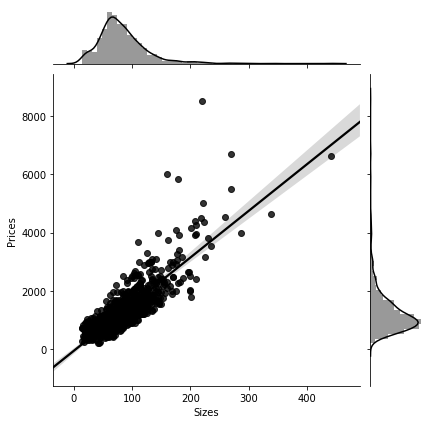

In [27]:
plot = sns.jointplot(x = 'Sizes', y = 'Prices', data = rent_data, color = 'k', kind = 'reg')
plot.savefig('prices_sizes_scatterplot_rentdata.png')

#### Our data distribution looks good. We don't seem to have any outliers, although we have some pricey apartments in our dataset, nothing that requires additional filtering though. 

#### Finally, let's average all values per neighborhood and create two new columns. One will have the average price per square meter and the other will have the number of available places within each neighborhood.

            Prices       Sizes  Price_per_square_meter  Available_places
count    84.000000   84.000000               84.000000         84.000000
mean   1175.150014   81.782018               14.323448         12.011905
std     448.622948   22.373934                3.288314         10.223401
min     510.000000   35.000000                7.911392          1.000000
25%     901.617917   65.967500               11.647632          4.000000
50%    1061.166667   79.779107               13.697520         10.000000
75%    1326.429063   92.619000               16.077764         18.000000
max    3184.000000  205.008000               24.003956         47.000000


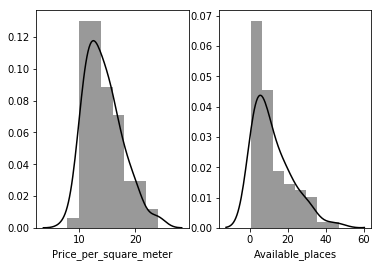

In [42]:
rent_data_groupped = rent_data.groupby('Neighborhood').mean()
rent_data_groupped

rent_data_groupped['Price_per_square_meter'] = rent_data_groupped['Prices'] / rent_data_groupped['Sizes']
rent_data_groupped['Available_places']       = rent_data.groupby('Neighborhood').count().Prices
print(rent_data_groupped.describe())

fig, ax = plt.subplots(1,2)
sns.distplot(rent_data_groupped['Price_per_square_meter'], ax = ax[0], color = 'k')
sns.distplot(rent_data_groupped['Available_places'], ax = ax[1], color = 'k')
fig.savefig('price_availability_histogram_rentdata.png')

#### This is clearly not a perfect solution, as we have neighborhoods with only a single entry since the minimum in our Available_places column is 1. Most neighborhoods, however, had at least 10 listings to compose the normalized price, which is decent. Ideally, we would scrape additional websites to increase our database, but for our proof of concept it is enough. Let's look at it in a map, to visualize the price distribution across Hamburg.

In [41]:
hamburg_neigh_map = folium.Map(location = [hamburg_neigh.Latitude.mean(), hamburg_neigh.Longitude.mean()], zoom_start = 10)

# Add the color for the chloropleth:
hamburg_neigh_map.choropleth(geo_data = geojson_file, name = 'Hamburg Neighborhoods', data = rent_data_groupped.reset_index(),
                             columns = ['Neighborhood', 'Price_per_square_meter'], fill_color = 'YlOrRd',
                             fill_opacity = 0.8, highlight = True, key_on = 'feature.properties.name',
                             legend_name = 'Average rental price per Neighborhood in Hamburg (Euros/sqr(m))')
folium.LayerControl().add_to(hamburg_neigh_map)

hamburg_neigh_map

#### As we can see, we have some missing values (light yellow). Ideally, we would search for a complimentary website to scrape more data from, and hopefully fill all those empty neighborhoods. For now, however, we will just calculate the missing data as the average of the closest three neighborhoods with data available. To estimate the three closest neighborhoods, we will use the haversine equation.
#### Let's include this price data into our base dataframe "hamburg_neigh", joining on the Neighborhood column, and fill the missing values. Again, we will only do this if updateWeights is set to True.

In [105]:
if updateWeights:
    hamburg_neigh = hamburg_neigh.join(rent_data_groupped[['Price_per_square_meter']], on = 'Neighborhood', how = 'left')

    # First, let's get only the missing data and the respective coordinates
    missing  = np.isnan(hamburg_neigh['Price_per_square_meter'])
    lat_miss = hamburg_neigh.Latitude[missing]
    lon_miss = hamburg_neigh.Longitude[missing]

    # And now the coordinates of non-missing data points
    lats = hamburg_neigh.Latitude[~missing]
    lons = hamburg_neigh.Longitude[~missing]

    for l in range(lat_miss.size):
        # Use the haversine equation to find the distance between the missing point being evaluated and all valid points
        dlon = np.radians(lons) - np.radians(lon_miss.iloc[l])
        dlat = np.radians(lats) - np.radians(lat_miss.iloc[l])
        a    = np.sin(dlat/2)**2 + np.cos(np.radians(lat_miss.iloc[l])) * \
               np.cos(np.radians(lats)) * np.sin(dlon/2)**2
        dist = 2 * np.arcsin(np.sqrt(a)) * 6371 # 6371 is the Earth's radius in kilometers

        # Sort the distance and grab the three closest valid points
        valid_id = dist.sort_values().index[:3]

        # And use those index to calculate the average rent price and put it into the correct missing row
        hamburg_neigh['Price_per_square_meter'].iloc[lat_miss.index[l]] = hamburg_neigh['Price_per_square_meter'].iloc[valid_id].mean()

hamburg_neigh.sort_values('Neighborhood').head()

C:\Users\Mihael\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Neighborhood   Latitude  Longitude  Price_per_square_meter
92        Allermöhe  53.478754  10.149814               11.130398
59       Alsterdorf  53.611935  10.014369               15.591188
27       Altengamme  53.443418  10.286941               10.041270
7       Altenwerder  53.512992   9.903628               14.334785
8   Altona-Altstadt  53.551405   9.948504               16.262737

#### We can see that the value for Altenwerder, that was previously missing, is now defined. Let's look at our map again.

In [109]:
hamburg_neigh_map = folium.Map(location = [hamburg_neigh.Latitude.mean(), hamburg_neigh.Longitude.mean()], zoom_start = 10)
 
# Add the color for the chloropleth:
hamburg_neigh_map.choropleth(geo_data = geojson_file, name = 'Hamburg Neighborhoods', data = hamburg_neigh,
                             columns = ['Neighborhood', 'Price_per_square_meter'], fill_color = 'YlOrRd',
                             fill_opacity = 0.8, highlight = True, key_on = 'feature.properties.name',
                             legend_name = 'Average rental price per Neighborhood in Hamburg (Euros/sqr(m))')
folium.LayerControl().add_to(hamburg_neigh_map)

hamburg_neigh_map

#### Great, no more missing values. And our interpolation procedure did not create anything that looks out of place, that is important as well. With this step done, we have finished gathering the necessary price data from ImmobilienScout24.

### 2.2 Now we move on to gather data from the different venues available around each neighborhood. We will use Foursquare as our data source in this step.

#### First, let's define our Foursquare credentials and the base api url.

In [59]:
foursqr_api = 'https://api.foursquare.com/v2/venues/'
params      = {'client_id'    : 'My_id',
               'client_secret': 'My_secret',
               'v'            : '20180605',
               'radius'       : '500',
               'll'           : '',
               'categoryId'   : '',
               'limit'        : '20'}

#### We have 103 neighborhoods. To create our recommender system, we want to make sure and try to sample each category for each neighorhood. We will search for up to 20 venues for each neighorhood, within the 10 large scale categories available on foursquare (https://developer.foursquare.com/docs/build-with-foursquare/categories/). We will also use a 500 m radius around each neighborhood central coordinate. We try to limit the search radius to hopefully create more identitiy within each neighborhood. Specially considering that some neighborhoods are quite small and in the city center, where the offer of venues is likely large.

#### We will start by defining two functions. One will grab all categoryIds associated with the 10 major categories in Foursquare, along with all 4 children depths for in each category. The second function will loop through each neighborhood doing a search query, for each of the 10 top categoryIds we grabbed. This should give us a representative view on what is available for each neighborhood within each category we are interested in.

In [57]:
def get_foursquare_categories(params):
    """
    Need to prescribe a parameters dictionary containing your client_id, client_secret and version "v" of the API.
    Returns two dictionaries, the first with the name of the top 10 categories in Foursquare, along with all
    children categories within each of those. The second contains the categoryId for the 10 top level categories.
    """
    results = get(url = 'https://api.foursquare.com/v2/venues/categories', params = {'client_id': params['client_id'],
                                                                                     'client_secret': params['client_secret'],
                                                                                     'v': params['v']}).json()
    categories   = {}
    categoriesId = {}
    for c in results['response']['categories']:
        l = []

        for cc in c['categories']:
            l.append(cc['name'])

            if len(cc['categories']) > 0:
                for ccc in cc['categories']:
                    l.append(ccc['name'])

                    if len(ccc['categories']) > 0:
                        for cccc in ccc['categories']:
                            l.append(cccc['name'])

                            if len(cccc['categories']) > 0:
                                for ccccc in cccc['categories']:
                                    l.append(ccccc['name'])

        categories[c['name']]   = l.copy()
        categoriesId[c['name']] = c['id']

    print('We have {} categories. They are:'.format(len(categories.keys())))
    print(categories.keys())
    return categories, categoriesId

def search_venues(df_in, categoriesId, params):
    """
    Perform a search query in the Foursquare API based on information from df_in. df_in must have at least 3 columns,
    named "Neighborhood", "Latitude" and "Longitude". Radius and limit search parameters must be set on the params 
    dictionary, along with client_id, client_secret and version "v" and passed in a dictionary of categoryIds.
    
    Returns a pandas DataFrame with the above named columns, along with information on up to "limit" of venues for each
    neighborhood, latitude, longitude triplet, across all categoryIds.
    """
    headers = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueCategory']
    venues  = pd.DataFrame(columns = headers)
    for neighb, lat, lon in zip(df_in.Neighborhood, df_in.Latitude, df_in.Longitude):
        params['ll'] = str(lat) + ',' + str(lon)

        for cat in categoriesId.keys():
            params['categoryId'] = categoriesId[cat]
            results              = get(url = 'https://api.foursquare.com/v2/venues/search', params = params).json()

            try:
                for v in results['response']['venues']:
                    venues = venues.append({headers[0]: neighb,
                                            headers[1]: lat,
                                            headers[2]: lon,
                                            headers[3]: v['name'],
                                            headers[4]: v['categories'][0]['name']}, ignore_index = True)
            except KeyError:
                continue # No information was found for this combination of coordinates and categoryId
                
    return venues

#### Now, if our updateWeights flag is set to True, we can execute both functions and grab the necessary Foursquare data. Otherwise, we just load the data we have on disk.

In [51]:
if updateWeights:
    categories, categoriesId = get_foursquare_categories(params)
    hamburg_venues           = search_venues(hamburg_neigh, categoriesId, params)
    hamburg_venues.to_msgpack('hamburg_neighborhoods_foursquaredata.msgpack')
else:
    hamburg_venues = pd.read_msgpack('hamburg_neighborhoods_foursquaredata.msgpack')
    categories     = {'Arts & Entertainment': '', 'College & University': '', 'Event': '', 'Food': '', 
                      'Nightlife Spot': '', 'Outdoors & Recreation': '', 'Professional & Other Places': '',
                      'Residence': '', 'Shop & Service': '', 'Travel & Transport': ''}

hamburg_venues.head()

Neighborhood   Latitude  Longitude                 VenueName  \
0   Spadenland  53.490067  10.064322  Gartenfreunde Spadenland   
1   Spadenland  53.490067  10.064322  Sportbootschule Nautilus   
2   Spadenland  53.490067  10.064322         Gemüsehof Reimers   
3   Spadenland  53.490067  10.064322                Gemüsefrau   
4   Spadenland  53.490067  10.064322       H Spadenländer Ecke   

     VenueCategory  
0           Garden  
1  Harbor / Marina  
2   Farmers Market  
3   Farmers Market  
4         Bus Stop

#### Let's see how many venues we have for each neighborhood. 

In [85]:
venues_groupped         = hamburg_venues[['Neighborhood', 'Latitude']].groupby('Neighborhood').count().reset_index()
venues_groupped.columns = ['Neighborhood', 'Count']
print('We have a total of {} venues!'.format(venues_groupped.Count.sum()))
print(venues_groupped.describe())

hamburg_venues_map = folium.Map(location = [hamburg_neigh.Latitude.mean(), hamburg_neigh.Longitude.mean()], zoom_start = 10)
 
# Add the color for the chloropleth:
hamburg_venues_map.choropleth(geo_data = geojson_file, name = 'Hamburg Neighborhoods', data = venues_groupped,
                             columns = ['Neighborhood', 'Count'], fill_color = 'YlOrRd',
                             fill_opacity = 0.8, highlight = True, key_on = 'feature.properties.name',
                             legend_name = 'Number of Venues per Neighborhood')
folium.LayerControl().add_to(hamburg_venues_map)

hamburg_venues_map

We have a total of 6136 venues!
            Count
count   97.000000
mean    63.257732
std     54.519354
min      1.000000
25%     17.000000
50%     48.000000
75%    108.000000
max    174.000000


#### We found a total of 6136 venues. Most of them were on neighborhoods in central hamburg, while regions in the outskirts and the SE part had the least amounts. These are probably quieter, more residential areas, and very small business might not even be registered in the Foursquare database, so these regions should be evaluated with care.
#### Now let's see how many unique categories we found.

In [53]:
unique_categories = hamburg_venues.VenueCategory.unique()
print('We found {} unique categories.'.format(len(unique_categories)))

We found 474 unique categories.


#### 474 unique categories. This is clearly too diverse to build a recommender system with. Instead of these categories, let's grab the top level categories from Foursquare and see if that provides a better general set of categories.

In [61]:
hamburg_venues_topcat = hamburg_venues[['Neighborhood', 'VenueName', 'VenueCategory']]

for k in categories.keys():
    hamburg_venues_topcat.replace(to_replace = categories[k], value = k, inplace = True)

hamburg_venues_topcat.head()

Neighborhood                 VenueName          VenueCategory
0   Spadenland  Gartenfreunde Spadenland  Outdoors & Recreation
1   Spadenland  Sportbootschule Nautilus  Outdoors & Recreation
2   Spadenland         Gemüsehof Reimers         Shop & Service
3   Spadenland                Gemüsefrau         Shop & Service
4   Spadenland       H Spadenländer Ecke     Travel & Transport

VenueCategory
Arts & Entertainment            493
College & University            367
Event                             7
Food                            919
Nightlife Spot                  495
Outdoors & Recreation           779
Professional & Other Places    1032
Residence                       429
Shop & Service                 1029
Travel & Transport              586
Name: VenueName, dtype: int64


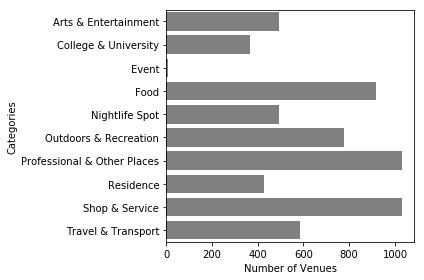

In [82]:
top = hamburg_venues_topcat.groupby('VenueCategory').count()['VenueName']
bar = sns.barplot(x = top, y = top.index, color = 'gray')
bar.set_xlabel('Number of Venues')
bar.set_ylabel('Categories')

plt.tight_layout()
plt.savefig('number_of_venues_per_category.png')
print(top)

#### At this category level, we have values for all categories. This is much more manageable for our recommender system. We mostly did not find anything on the Event category, but all other categories seem to have a reasonable number of entries. Now we create our data frame with these simplified categories, dropping for now the Event category. 

In [133]:
hamburg_venues_simplified                  = hamburg_venues.copy()
hamburg_venues_simplified['VenueCategory'] = hamburg_venues_topcat.VenueCategory

vi = hamburg_venues_simplified[hamburg_venues_simplified.VenueCategory == 'Event'].index
hamburg_venues_simplified.drop(vi, inplace = True) # Remove Event entries

print(hamburg_venues_simplified.shape)
hamburg_venues_simplified.head()

(6129, 5)


Neighborhood   Latitude  Longitude                 VenueName  \
0   Spadenland  53.490067  10.064322  Gartenfreunde Spadenland   
1   Spadenland  53.490067  10.064322  Sportbootschule Nautilus   
2   Spadenland  53.490067  10.064322         Gemüsehof Reimers   
3   Spadenland  53.490067  10.064322                Gemüsefrau   
4   Spadenland  53.490067  10.064322       H Spadenländer Ecke   

           VenueCategory  
0  Outdoors & Recreation  
1  Outdoors & Recreation  
2         Shop & Service  
3         Shop & Service  
4     Travel & Transport

#### Finally, we have 6129 Venues across 9 distinct categories. To use in our recommender systems, let's create a one hot encoding of these values. We will then sum up all values across the same categories for each neighborhood.

In [136]:
hamburg_venues_onehot = pd.get_dummies(hamburg_venues_simplified.VenueCategory)

# Add back the neighborhood column and reorder it to first position
hamburg_venues_onehot['Neighborhood'] = hamburg_venues_simplified['Neighborhood']

col_order             = [hamburg_venues_onehot.columns[-1]] + list(hamburg_venues_onehot.columns[:-1])
hamburg_venues_onehot = hamburg_venues_onehot[col_order]

hamburg_venues_groupped = hamburg_venues_onehot.groupby('Neighborhood').sum()
hamburg_venues_groupped.head()

Arts & Entertainment  College & University  Food  \
Neighborhood                                                        
Allermöhe                           1                     0     0   
Alsterdorf                          0                     1     9   
Altenwerder                         0                     0     0   
Altona-Altstadt                    21                    15    20   
Altona-Nord                        18                    13    21   

                 Nightlife Spot  Outdoors & Recreation  \
Neighborhood                                             
Allermöhe                     0                      4   
Alsterdorf                    3                      8   
Altenwerder                   0                      1   
Altona-Altstadt              18                     16   
Altona-Nord                  19                     16   

                 Professional & Other Places  Residence  Shop & Service  \
Neighborhood                                                              
Allermöhe                                  0          0               2   
Alsterdorf                                13          7              14   
Altenwerder                               10          0               1   
Altona-Altstadt                           21         19              19   
Altona-Nord                               18          9              16   

                 Travel & Transport  
Neighborhood                         
Allermöhe                         0  
Alsterdorf                        5  
Altenwerder                       1  
Altona-Altstadt                  16  
Altona-Nord                      12

#### Now we have a data frame with the frequency of occurrence of each category for all neighborhoods in Hamburg. Let's put this information in our main data frame "hamburg_neigh". Once again, we only do this step with our updateWeights flag is set to True.

In [137]:
if updateWeights:
    hamburg_neigh = hamburg_neigh.join(hamburg_venues_groupped, on = 'Neighborhood', how = 'left')

hamburg_neigh.sort_values('Neighborhood').head()

Neighborhood   Latitude  Longitude  Price_per_square_meter  \
92        Allermöhe  53.478754  10.149814               11.130398   
59       Alsterdorf  53.611935  10.014369               15.591188   
27       Altengamme  53.443418  10.286941               10.041270   
7       Altenwerder  53.512992   9.903628               14.334785   
8   Altona-Altstadt  53.551405   9.948504               16.262737   

    Arts & Entertainment  College & University  Food  Nightlife Spot  \
92                   1.0                   0.0   0.0             0.0   
59                   0.0                   1.0   9.0             3.0   
27                   NaN                   NaN   NaN             NaN   
7                    0.0                   0.0   0.0             0.0   
8                   21.0                  15.0  20.0            18.0   

    Outdoors & Recreation  Professional & Other Places  Residence  \
92                    4.0                          0.0        0.0   
59                    8.0                         13.0        7.0   
27                    NaN                          NaN        NaN   
7                     1.0                         10.0        0.0   
8                    16.0                         21.0       19.0   

    Shop & Service  Travel & Transport  
92             2.0                 0.0  
59            14.0                 5.0  
27             NaN                 NaN  
7              1.0                 1.0  
8             19.0                16.0

#### We're almost there, but let's try to optimize our categories a bit. For exemple, the Residence category mostly tracks residences, elderly homes and similar objects. This is not particularly useful for our application as is. We can, however, create a quiet index, by pondering the amount of Residence + Outdoors & Recreation entries by the amount of Nightlife Spot + Shop & Service entries. The idea here is that a more quiet neighorhood would have a higher amount of the former two and a lesser amount of the latter combination. 
#### We will take the ratio of each category in relation to the max occurence of that category for all neighborhoods, sum both category pairs and finally subtract the results. In the resulting index, positive values will indicate a quieter neighborhood and a value of zero will be the indication of a balance between those two category sets. After that, we can drop the Residence column.

In [90]:
if updateWeights:
    residence = hamburg_neigh.Residence / hamburg_neigh.Residence.max()
    outdoors  = hamburg_neigh['Outdoors & Recreation'] / hamburg_neigh['Outdoors & Recreation'].max()
    nightlife = hamburg_neigh['Nightlife Spot'] / hamburg_neigh['Nightlife Spot'].max()
    services  = hamburg_neigh['Shop & Service'] / hamburg_neigh['Shop & Service'].max()

    hamburg_neigh['Quiet Index'] = (residence + outdoors) - (nightlife + services)
    hamburg_neigh.drop('Residence', axis = 1, inplace = True)

print(hamburg_neigh['Quiet Index'].describe())
hamburg_neigh_map = folium.Map(location = [hamburg_neigh.Latitude.mean(), hamburg_neigh.Longitude.mean()], zoom_start = 10)
 
# Add the color for the chloropleth:
hamburg_neigh_map.choropleth(geo_data = geojson_file, name = 'Hamburg Neighborhoods', data = hamburg_neigh,
                             columns = ['Neighborhood', 'Quiet Index'], fill_color = 'RdYlBu',
                             fill_opacity = 0.8, highlight = True, key_on = 'feature.properties.name',
                             threshold_scale = np.linspace(0,1.000001,6).tolist(), reset = True,
                             legend_name = 'Quiet Index')
folium.LayerControl().add_to(hamburg_neigh_map)

hamburg_neigh_map

count    103.000000
mean       0.459813
std        0.173741
min        0.000000
25%        0.335340
50%        0.493194
75%        0.558901
max        1.000000
Name: Quiet Index, dtype: float64


#### As we can see from above, most of our neighborhoods fall close to the 0 value, meaning they are not too quiet or busy. However, we have a higher number of comparatively noisier neighborhoods then busy ones, by the prevalence of warm color tones in comparison to the colder tones. 
#### Of note is some of the neighborhoods in the outskirts of Hamburg. They are being categorized as very noise, which is unexpected as some of them are considered rural areas. Neuengamme is one of those in the SE, let's take a look at its values.

In [139]:
hamburg_neigh[hamburg_neigh.Neighborhood == 'Neuengamme']

Neighborhood   Latitude  Longitude  Price_per_square_meter  \
95   Neuengamme  53.434509  10.214131                7.911392   

    Arts & Entertainment  College & University  Food  Nightlife Spot  \
95                   NaN                   NaN   NaN             NaN   

    Outdoors & Recreation  Professional & Other Places  Shop & Service  \
95                    NaN                          NaN             NaN   

    Travel & Transport  Quiet Index  
95                 NaN          NaN

#### And that is our answer. We got no venue information for this neighborhood from Foursquare and all category fields are defined as NaN. Being a rural neighborhood, this is probably the reason why there is nothing catalogged there, and is essentially not going to be well represented in our recommender system or any visualization that we produce going forward. Let's see if there are other neighborhoods in the same situation.

In [140]:
nans = pd.isnull(hamburg_neigh).any(1).nonzero()[0]
hamburg_neigh.iloc[nans,:]

Neighborhood   Latitude  Longitude  Price_per_square_meter  \
11             Francop  53.503233   9.862218               13.280152   
27          Altengamme  53.443418  10.286941               10.041270   
57         Kirchwerder  53.424064  10.181927               10.378788   
73  Wohlsdorf-Ohlstedt  53.704840  10.152524               12.254899   
95          Neuengamme  53.434509  10.214131                7.911392   
96           Reitbrook  53.466878  10.140683               12.399387   

    Arts & Entertainment  College & University  Food  Nightlife Spot  \
11                   NaN                   NaN   NaN             NaN   
27                   NaN                   NaN   NaN             NaN   
57                   NaN                   NaN   NaN             NaN   
73                   NaN                   NaN   NaN             NaN   
95                   NaN                   NaN   NaN             NaN   
96                   NaN                   NaN   NaN             NaN   

    Outdoors & Recreation  Professional & Other Places  Shop & Service  \
11                    NaN                          NaN             NaN   
27                    NaN                          NaN             NaN   
57                    NaN                          NaN             NaN   
73                    NaN                          NaN             NaN   
95                    NaN                          NaN             NaN   
96                    NaN                          NaN             NaN   

    Travel & Transport  Quiet Index  
11                 NaN          NaN  
27                 NaN          NaN  
57                 NaN          NaN  
73                 NaN          NaN  
95                 NaN          NaN  
96                 NaN          NaN

#### As we can see, there are 6 neighborhoods without information from Foursquare. Altengamme, Neuengamme, Kirchwerder and Reitbrook are the ones in the SE corner, Wohlsdorf-Ohlstedt is the one in the N, and Francop is the one in the SW. We could try increasing the radius, to hopefully capture some venues in these regions, but this would dillute the information recovered around the city center. An alternative would be to try to change radius based on the distance between the neighborhood in question and the city center or to use a different provider for the venues data. We will keep this in mind for future improvements to the methodology but, for now, we will set all NaN values to zero.

In [141]:
hamburg_neigh.iloc[nans,4:] = 0
hamburg_neigh.iloc[nans,:]

Neighborhood   Latitude  Longitude  Price_per_square_meter  \
11             Francop  53.503233   9.862218               13.280152   
27          Altengamme  53.443418  10.286941               10.041270   
57         Kirchwerder  53.424064  10.181927               10.378788   
73  Wohlsdorf-Ohlstedt  53.704840  10.152524               12.254899   
95          Neuengamme  53.434509  10.214131                7.911392   
96           Reitbrook  53.466878  10.140683               12.399387   

    Arts & Entertainment  College & University  Food  Nightlife Spot  \
11                   0.0                   0.0   0.0             0.0   
27                   0.0                   0.0   0.0             0.0   
57                   0.0                   0.0   0.0             0.0   
73                   0.0                   0.0   0.0             0.0   
95                   0.0                   0.0   0.0             0.0   
96                   0.0                   0.0   0.0             0.0   

    Outdoors & Recreation  Professional & Other Places  Shop & Service  \
11                    0.0                          0.0             0.0   
27                    0.0                          0.0             0.0   
57                    0.0                          0.0             0.0   
73                    0.0                          0.0             0.0   
95                    0.0                          0.0             0.0   
96                    0.0                          0.0             0.0   

    Travel & Transport  Quiet Index  
11                 0.0          0.0  
27                 0.0          0.0  
57                 0.0          0.0  
73                 0.0          0.0  
95                 0.0          0.0  
96                 0.0          0.0

In [95]:
print('There are {} with a Quiet Index above 0.6'.format(hamburg_neigh[hamburg_neigh['Quiet Index'] > 0.6].count().Neighborhood))
print('There are {} with a Quiet Index below 0.4'.format(hamburg_neigh[hamburg_neigh['Quiet Index'] < 0.4].count().Neighborhood))

hamburg_neigh_map = folium.Map(location = [hamburg_neigh.Latitude.mean(), hamburg_neigh.Longitude.mean()], zoom_start = 10)
 
# Add the color for the chloropleth:
hamburg_neigh_map.choropleth(geo_data = geojson_file, name = 'Hamburg Neighborhoods', data = hamburg_neigh,
                             columns = ['Neighborhood', 'Quiet Index'], fill_color = 'RdYlBu',
                             fill_opacity = 0.8, highlight = True, key_on = 'feature.properties.name',
                             threshold_scale = np.linspace(0,1.000001,6).tolist(), reset = True,
                             legend_name = 'Quiet Index')
folium.LayerControl().add_to(hamburg_neigh_map)
hamburg_neigh_map

There are 13 with a Quiet Index above 0.6
There are 31 with a Quiet Index below 0.4


#### Finally, let's scale our price_per_square_meter into a Price Index information and the general categories as well. For the Price Index, we'll just scale every value by the column max and subtract that from 1. That way, we'll have a 0 to 1 scale, with the higher value representing the cheaper neighborhoods. After that, we'll use the MinMaxScaler to scale every content-based input in our data frame to the 0 to 1 range.

In [142]:
if updateWeights:
    hamburg_neigh['Price Index'] = 1 - (hamburg_neigh.Price_per_square_meter / hamburg_neigh.Price_per_square_meter.max())

    # For our standard scaler, let's instantiate the Scaler
    scaler                   = MinMaxScaler()
    hamburg_neigh.iloc[:,4:] = scaler.fit_transform(hamburg_neigh.iloc[:,4:])

hamburg_neigh.sort_values('Neighborhood').head()

Neighborhood   Latitude  Longitude  Price_per_square_meter  \
92        Allermöhe  53.478754  10.149814               11.130398   
59       Alsterdorf  53.611935  10.014369               15.591188   
27       Altengamme  53.443418  10.286941               10.041270   
7       Altenwerder  53.512992   9.903628               14.334785   
8   Altona-Altstadt  53.551405   9.948504               16.262737   

    Arts & Entertainment  College & University      Food  Nightlife Spot  \
92              0.043478              0.000000  0.000000        0.000000   
59              0.000000              0.047619  0.333333        0.136364   
27              0.000000              0.000000  0.000000        0.000000   
7               0.000000              0.000000  0.000000        0.000000   
8               0.913043              0.714286  0.740741        0.818182   

    Outdoors & Recreation  Professional & Other Places  Shop & Service  \
92                   0.20                     0.000000        0.083333   
59                   0.40                     0.565217        0.583333   
27                   0.00                     0.000000        0.000000   
7                    0.05                     0.434783        0.041667   
8                    0.80                     0.913043        0.791667   

    Travel & Transport  Quiet Index  Price Index  
92            0.000000     0.573822     0.799969  
59            0.263158     0.514136     0.522774  
27            0.000000     0.493194     0.867648  
7             0.052632     0.498953     0.600847  
8             0.842105     0.590052     0.481043

#### Almost there! Our content matrix, represented by the "hamburg_neigh" data frame is almost complete. The only thing lacking is a Distance Index column. Different from all other columns, however, we cannot compute this index in advance because it depends on the target address that we are interested in. We will initialize this column as zero, for now, and fill it up during execution.

In [143]:
hamburg_neigh['Distance Index'] = 0
hamburg_neigh.sort_values('Neighborhood').head()

Neighborhood   Latitude  Longitude  Price_per_square_meter  \
92        Allermöhe  53.478754  10.149814               11.130398   
59       Alsterdorf  53.611935  10.014369               15.591188   
27       Altengamme  53.443418  10.286941               10.041270   
7       Altenwerder  53.512992   9.903628               14.334785   
8   Altona-Altstadt  53.551405   9.948504               16.262737   

    Arts & Entertainment  College & University      Food  Nightlife Spot  \
92              0.043478              0.000000  0.000000        0.000000   
59              0.000000              0.047619  0.333333        0.136364   
27              0.000000              0.000000  0.000000        0.000000   
7               0.000000              0.000000  0.000000        0.000000   
8               0.913043              0.714286  0.740741        0.818182   

    Outdoors & Recreation  Professional & Other Places  Shop & Service  \
92                   0.20                     0.000000        0.083333   
59                   0.40                     0.565217        0.583333   
27                   0.00                     0.000000        0.000000   
7                    0.05                     0.434783        0.041667   
8                    0.80                     0.913043        0.791667   

    Travel & Transport  Quiet Index  Price Index  Distance Index  
92            0.000000     0.573822     0.799969               0  
59            0.263158     0.514136     0.522774               0  
27            0.000000     0.493194     0.867648               0  
7             0.052632     0.498953     0.600847               0  
8             0.842105     0.590052     0.481043               0

#### Now all that is left is to save this data frame on disk, so we don't have to repeat all these data gathering steps again within short periods of time. We defined a short time, for now, as 1 month, but this would very much be refined with use.

In [145]:
if updateWeights:
    hamburg_neigh.to_msgpack('hamburg_neighborhoods_weights_' + datetime.now().strftime("%d%m%Y") + '.msgpack')

#### This is our final data frame, which contains the average weight of all categories in our recommender system in a scale from 0 to 1. For every property on the data frame, a higher value will indicate a neighborhood more adequate in terms of the property being evaluated.
#### To gather some understanding about how our neighborhoods rank among each other, lets get the top 5 neighborhoods for each category.

In [149]:
top5 = {}
for c in hamburg_neigh.columns[4:-1]:
    top5[c] = hamburg_neigh[['Neighborhood', c]].sort_values(c, ascending = False).iloc[:5,0].values

hamburg_top5 = pd.DataFrame(top5)

hamburg_top5.index = np.arange(1,6)
hamburg_top5

Arts & Entertainment College & University              Food  \
1            St. Pauli           Rotherbaum  Hamburg-Altstadt   
2            HafenCity             Neustadt        Rotherbaum   
3      Altona-Altstadt         Sternschanze           Harburg   
4              Harburg            St. Georg         HafenCity   
5            St. Georg     Hamburg-Altstadt          Dulsberg   

    Nightlife Spot Outdoors & Recreation Professional & Other Places  \
1         Ottensen             HafenCity                    Ottensen   
2      Hammerbrook              Neustadt                   Eppendorf   
3        St. Georg      Hamburg-Altstadt                    Neustadt   
4      Altona-Nord           Barmbek-Süd             Altona-Altstadt   
5  Altona-Altstadt               Harburg                Harvestehude   

  Shop & Service Travel & Transport   Quiet Index Price Index  
1   Sternschanze          St. Georg  Groß Borstel  Neuengamme  
2      St. Georg        Hammerbrook    Rotherbaum  Altengamme  
3      St. Pauli       Sternschanze    Bahrenfeld   Hausbruch  
4   Hoheluft-Ost          HafenCity  Neuallermöhe    Heimfeld  
5     Uhlenhorst           Neustadt      Ohlsdorf    Wilstorf

#### And finally see how the neighborhoods rank when we consider the sum of their scores across all categories. We'll plot this one in a map.

In [107]:
scaler = MinMaxScaler() # Instantiate the scaler

best_neigh                  = pd.DataFrame(columns = ['Neighborhood', 'Average Score'])
best_neigh['Neighborhood']  = hamburg_neigh.Neighborhood
best_neigh['Average Score'] = scaler.fit_transform(hamburg_neigh.iloc[:,3:].sum(axis = 1)[:,None])

best_neigh_map = folium.Map(location = [hamburg_neigh.Latitude.mean(), hamburg_neigh.Longitude.mean()], zoom_start = 10)
 
# Add the color for the chloropleth:
best_neigh_map.choropleth(geo_data = geojson_file, name = 'Hamburg Neighborhoods', data = best_neigh,
                          columns = ['Neighborhood', 'Average Score'], fill_color = 'YlOrRd',
                          fill_opacity = 0.8, highlight = True, key_on = 'feature.properties.name',
                          legend_name = 'Average Neighborhood Score')
folium.LayerControl().add_to(best_neigh_map)

best_neigh_map

#### From our data, it looks like the neighborhoods in central Hamburg offer the overall best living conditions when all factors are considered. This is usually the case, considering the vast offer of services and good mobility options normally associated with the city center. But we can see that some other neighborhoods, more apart from the center, also had good scores. Harburg in the south, Bergedorf in the east/southeast, Langehorn and Poppenbüttel in the north and Blankenese in the west all stand as good options.

#### It is also important to recognize that this average score map resembles the map with the number of venues per neighborhood seen above. This is a clear indication that our results are heavily biased by the availability of venues, which is to be expected considering this is our only source of venues data. Ideally, we would try to gather data from another provider to hopefully decrease this bias.

#### Most likely, we could have gotten to the overall same conclusions via some google searches on neighborhoods around Hamburg. The value in this, however, is that now we have a content-based matrix of weights for each of our neighorhoods. If we combine this with a user generated profile, we can create a customized neighborhood index suited to the user's preferences.

## 3. Our Hamburg's neighborhood recommender system.

#### To finish our recommender system, we first have to define a function to calculate the Distance Index. This index will reflect the travel distance between each neighborhood center and the address provided by the client. To calculate this travel distance, we will use the BingMaps API. We can then use geopy's Nominatim to grab the latitude and longitude of any address provided by the client. We feed both our hamburg_neigh data and these coordinates to our get_distance_index() function to complete our content matrix.
#### We also want to make sure that the commute category has a big impact in the neighborhood selection. Currently, all categories have a max value of 1, and under normal circunstances commute would represent 1/11 of the overall importance when all categories are rated the same. To be able to boost the importance of commute, we will add a boost argument to the function. This can be tailored experimentaly.

In [80]:
def get_distance_index(df_in, address):
    """
    Returns df_in, with the "Distance Index" column filled. The distance index is calculated between
    all coordinate pairs in df_in and the latitude and longitude tuple defined by address.
    """
    params = {'wayPoint.1': '',
              'wayPoint.2': str(address[0]) + ',' + str(address[1]),
              'key': 'My_key'}

    distances = []
    for lat, lon in zip(df_in.Latitude, df_in.Longitude):
        params['wayPoint.1'] = str(lat) + ',' + str(lon)
        results              = get('http://dev.virtualearth.net/REST/v1/Routes/Driving', params = params).json()
        distances.append(results['resourceSets'][0]['resources'][0]['travelDuration'])
        
    df_in['Distance Index'] = 1 - (distances / np.max(distances))
    return df_in

### Now we can start applying our recommender system to a client's profile
#### We start by gathering information from a user's preference, based on the categories we have in our data frame. This could be done by a web formular, a dashboard or through a series of questions over e-mail or the phone, for example. We have 11 categories, so let's ask the user to rate his preferences for these 11 fields with a value between 1 and 5. An example questionnaire is below:

Hello and welcome to Hamburg! Finding accommodations can be daunting, especially when you don't know the city well. To help you get started in choosing where to live, we would like to ask you some questions to get to know you and your preferences a little bit better. Please, answer the 10 questions below on a scale from 1 to 5 (1 = not important / 5 = highly important).

01) How important would you rate having easily accessible Movie Theaters, Museums or General Entertainment venues nearby?  
02) How important would you rate having ease access to University facilities?  
03) How important would you rate having a lot of different Restaurants and Coffee Shops nearby?  
04) How important would you rate having an active night life in the neighborhood, with Bars, Pubs and Clubs?  
05) How important would you rate having close access to Outdoors activity areas and Sports Centers/Gyms?  
06) How important would you rate being in proximity of Service Providers and Business Centers?  
07) How important would you rate being in proximity to General Stores, Shopping Malls or General Services (e.g. ATM)?  
08) How important would you rate having good connections to the Public Transport System?  
09) How important would you rate being a quiet and calm neighborhood?  
10) How important would you rate rent costs?  
11) How important would you rate your commute distance?

#### Based on the questionnaire above, let's create 3 potential users and see how our recommender system performs. We will show the 5 top neighborhood suggestions for each user and plot a map of the score across all neighborhoods, highlighting only those neighborhoods for which the score is above 0.8. 
#### But first, we write a function to calculate the average score for each neighborhood based on a Series of user defined weights.

In [30]:
def get_user_recommendation(user_profile, content_matrix, address = '', boost = 5):
    """
    Calculates the average score of each neighborhood based upon a pre-defined user rating.
    Returns a data frame sorted according to the calculated average score for each neighorhood.
    Values are in the range 0 to 1, with 1 being the suggested "ideal" neighborhood location.
    """
    scaler                          = MinMaxScaler() # Instantiate a scaler
    user_profile['Price Index']    *= boost # Boost the Price and Distance Index
    user_profile['Distance Index'] *= boost
    
    # Define the coordinates for the client's given address, if pertinent
    if address != '':
        locator  = Nominatim(user_agent = 'myGeocoder')
        location = locator.geocode(address_n + ', Hamburg, Germany')
        address  = (location.latitude, location.longitude)
        df_user  = get_distance_index(content_matrix, address)
    else:
        df_user = content_matrix
        address = 0
        
    # Ensure the correct column order across the user profile and the content matrix
    columns = ['Arts & Entertainment', 'College & University', 'Food', 'Nightlife Spot', 'Outdoors & Recreation',
               'Professional & Other Places', 'Shop & Service', 'Travel & Transport', 'Quiet Index', 'Price Index',
               'Distance Index']
    user    = user_profile[columns]
    df_user = df_user[columns]

    # Create the output DataFrame and generate the user-averaged neighborhood score
    user_pref                  = pd.DataFrame(columns = ['Neighborhood', 'Average Score']) 
    user_pref['Neighborhood']  = content_matrix.Neighborhood 
    user_pref['Average Score'] = scaler.fit_transform(df_user.dot(user_profile)[:,None])
    
    return user_pref.sort_values('Average Score', ascending = False), address

#### User 1 - Young woman, mid 20s. Good job and not tight on money, likes to hit the town at night and loves going to the theater. Self-declared foodie. Prefers to come back home to a quieter neighborhood where she can recharge.

This would've been her answers:  
01) 4 > Arts & Entertainment   
02) 1 > College & University  
03) 5 > Food   
04) 5 > Nightlife Spot  
05) 2 > Outdoors & Recreation   
06) 1 > Professional & Other Places   
07) 2 > Shop & Service  
08) 4 > Travel & Transport  
09) 4 > Quiet Index  
10) 3 > Price Index  
11) 3 > Commute

In [75]:
address_n     = 'Hermelinweg, 8'
user          = pd.Series(index = hamburg_neigh.columns[4:], data = [4,1,5,5,2,1,2,4,4,3,3])
user, address = get_user_recommendation(user, hamburg_neigh.copy(), address = address_n, boost = 5)
print(user.head(5))

user_map = folium.Map(location = [hamburg_neigh.Latitude.mean(), hamburg_neigh.Longitude.mean()], zoom_start = 10)
 
# Add the color for the chloropleth:
user_map.choropleth(geo_data = geojson_file, name = 'Hamburg Neighborhoods', data = user,
                    columns = ['Neighborhood', 'Average Score'], fill_color = 'YlOrRd',
                    fill_opacity = 0.8, highlight = True, key_on = 'feature.properties.name',
                    threshold_scale = np.linspace(.8,1.000001,6).tolist(), reset = True,
                    legend_name = 'Top Neighborhoods for User Profile')
folium.LayerControl().add_to(user_map)

if address_n != '':
    folium.CircleMarker([address[0], address[1]], radius = 5, popup = address_n, color = 'k', fill = True,
                         fill_color = 'black', fill_opacity = 0.7, parse_html = False).add_to(user_map)

user_map

   Neighborhood  Average Score
99    Borgfelde       1.000000
16    St. Pauli       0.996621
82      Harburg       0.962619
66     Dulsberg       0.946630
36  Hammerbrook       0.931791


In [56]:
for i in user.Neighborhood.iloc[:5]:
    vi = rent_data[rent_data.Neighborhood == i]
    print('Found {} listings in {}, with rent offers between {} and {} €/month.'.format(vi.count().Neighborhood, 
                                                                                        i,
                                                                                        vi.Prices.min(),
                                                                                        vi.Prices.max()))

Found 5 listings in Borgfelde, with rent offers between 936.0 and 1500.0 €/month.
Found 4 listings in St. Pauli, with rent offers between 481.21 and 2704.0 €/month.
Found 32 listings in Harburg, with rent offers between 380.0 and 2330.0 €/month.
Found 4 listings in Dulsberg, with rent offers between 477.39 and 1209.19 €/month.
Found 11 listings in Hammerbrook, with rent offers between 625.0 and 1704.79 €/month.


#### User 2 - Familie of three. Well off, son starts in college soon. Value outdoor areas for sports and good entertainment options. Hates losing time with long commutes and traffic.
This would've been their answers:  
01) 4       > Arts & Entertainment   
02) 5       > College & University  
03) 2       > Food   
04) 1       > Nightlife Spot  
05) 5       > Outdoors & Recreation   
06) 1       > Professional & Other Places   
07) 2       > Shop & Service  
08) 1       > Travel & Transport  
09) 3       > Quiet Index  
10) 2       > Price Index  
11) 5       > Commute  

In [76]:
address_n     = 'Manteuffelstrasse, 20'
user          = pd.Series(index = hamburg_neigh.columns[4:], data = [4,5,2,1,5,1,2,1,3,2,5])
user, address = get_user_recommendation(user, hamburg_neigh.copy(), address = address, boost = 5)
print(user.head(5))

user_map = folium.Map(location = [hamburg_neigh.Latitude.mean(), hamburg_neigh.Longitude.mean()], zoom_start = 10)
 
# Add the color for the chloropleth:
user_map.choropleth(geo_data = geojson_file, name = 'Hamburg Neighborhoods', data = user,
                    columns = ['Neighborhood', 'Average Score'], fill_color = 'YlOrRd',
                    fill_opacity = 0.8, highlight = True, key_on = 'feature.properties.name',
                    threshold_scale = np.linspace(.8,1.000001,6).tolist(), reset = True,
                    legend_name = 'Top Neighborhoods for User Profile')
folium.LayerControl().add_to(user_map)
if address_n != '':
    folium.CircleMarker([address[0], address[1]], radius = 5, popup = address_n, color = 'k', fill = True,
                         fill_color = 'black', fill_opacity = 0.7, parse_html = False).add_to(user_map)

user_map

       Neighborhood  Average Score
8   Altona-Altstadt       1.000000
16        St. Pauli       0.991438
34         Ottensen       0.923846
82          Harburg       0.912439
38         Neustadt       0.907429


In [77]:
for i in user.Neighborhood.iloc[:5]:
    vi = rent_data[rent_data.Neighborhood == i]
    print('Found {} listings in {}, with rent offers between {} and {} €/month.'.format(vi.count().Neighborhood, 
                                                                                        i,
                                                                                        vi.Prices.min(),
                                                                                        vi.Prices.max()))

Found 8 listings in Altona-Altstadt, with rent offers between 630.0 and 2200.0 €/month.
Found 4 listings in St. Pauli, with rent offers between 481.21 and 2704.0 €/month.
Found 6 listings in Ottensen, with rent offers between 700.0 and 3050.0 €/month.
Found 32 listings in Harburg, with rent offers between 380.0 and 2330.0 €/month.
Found 11 listings in Neustadt, with rent offers between 890.92 and 1980.0 €/month.


#### User 3 - Retired senior. Values a quiet neighborhood and wants to be close to Parks or the River.

This would've been his answers:  
01) 3 > Arts & Entertainment  
02) 1 > College & University  
03) 1 > Food  
04) 1 > Nightlife Spot  
05) 5 > Outdoors & Recreation  
06) 1 > Professional & Other Places  
07) 3 > Shop & Service  
08) 3 > Travel & Transport  
09) 5 > Quiet Index  
10) 5 > Price Index    
11) 1 > Commute  

In [78]:
address_n     = ''
user          = pd.Series(index = hamburg_neigh.columns[4:], data = [3,1,1,1,5,1,3,3,5,5,1])
user, address = get_user_recommendation(user, hamburg_neigh.copy(), address = address, boost = 5)
print(user.head(5))

user_map = folium.Map(location = [hamburg_neigh.Latitude.mean(), hamburg_neigh.Longitude.mean()], zoom_start = 10)
 
# Add the color for the chloropleth:
user_map.choropleth(geo_data = geojson_file, name = 'Hamburg Neighborhoods', data = user,
                    columns = ['Neighborhood', 'Average Score'], fill_color = 'YlOrRd',
                    fill_opacity = 0.8, highlight = True, key_on = 'feature.properties.name',
                    threshold_scale = np.linspace(.8,1.000001,6).tolist(), reset = True,
                    legend_name = 'Top Neighborhoods for User Profile')
folium.LayerControl().add_to(user_map)
if address_n != '':
    folium.CircleMarker([address[0], address[1]], radius = 5, popup = address_n, color = 'k', fill = True,
                         fill_color = 'black', fill_opacity = 0.7, parse_html = False).add_to(user_map)

user_map

       Neighborhood  Average Score
99        Borgfelde       1.000000
16        St. Pauli       0.981198
82          Harburg       0.954602
18             Horn       0.882712
8   Altona-Altstadt       0.840756


In [79]:
for i in user.Neighborhood.iloc[:5]:
    vi = rent_data[rent_data.Neighborhood == i]
    print('Found {} listings in {}, with rent offers between {} and {} €/month.'.format(vi.count().Neighborhood, 
                                                                                        i,
                                                                                        vi.Prices.min(),
                                                                                        vi.Prices.max()))

Found 5 listings in Borgfelde, with rent offers between 936.0 and 1500.0 €/month.
Found 4 listings in St. Pauli, with rent offers between 481.21 and 2704.0 €/month.
Found 32 listings in Harburg, with rent offers between 380.0 and 2330.0 €/month.
Found 4 listings in Horn, with rent offers between 422.22 and 730.0 €/month.
Found 8 listings in Altona-Altstadt, with rent offers between 630.0 and 2200.0 €/month.


#### From these 3 users, we can see that there is a clear bias towards the central neighborhoods. This goes back to the bias we had identified from the Foursquare data. Ideally, we would look for more data on the neighborhoods outside the city center, to decrease the weight discrepancy. 

#### We could also try to curate the categories to only some specific entries, instead of using the whole of Foursquare categories. This, however, is likely to affect the outskirts neighborhoods disproportionally to the city center, so should be approached with care.

#### The weighted approach for the commute distance, however, does seem to work to minimize a bit the location bias. For user 2, when commute was highly important, Harburg score decrease in response, while neighborhood recommendation shifted towards the given address. This is a good sign that the boost parameter is working, and refining its value could improve the current system as well.

## Nevertheless, our recommender system works and we can use it to help newcomers to focus their search for accomodation to locations that are more inline with their personal expectations regarding their living spaces.